In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# LIBRARIES
#*********************
!cp drive/MyDrive/10_PROJECTS/photo_tagger/helpers.py .
!cp drive/MyDrive/10_PROJECTS/photo_tagger/mean_and_std.pt .

!pip install livelossplot

import torchvision.datasets
import torchvision.transforms as T
import torchvision.models
import torch.optim
import torch.nn.functional as F
from torch import nn
from helpers import *
import glob
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# SETTINGS
#**************************************************
batch_size = 32        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
n_epochs = 5        # number of epochs for training
#dropout = 0.4          # dropout for our model
learning_rate = 0.05  # Learning rate for SGD (or Adam)
momentum = 0.5 
weight_decay = 0.01     # regularization. Increase this to combat overfitting

In [ ]:
# DATA LOADERS
#*********************
data_loaders = get_data_loaders(batch_size=batch_size,valid_size=valid_size)

n_classes = len(data_loaders["train"].dataset.classes)

# visualization of one batch of data
#visualize_one_batch(data_loaders)

Reusing cached mean and std
Dataset mean: tensor([0.6048, 0.5671, 0.5215]), std: tensor([0.2576, 0.2616, 0.2875])
Reusing cached mean and std


In [ ]:
# TRANSFER MODEL: FREEZE BACKBONE AND THAW THE HEAD
#**************************************************

model = torchvision.models.resnet50(pretrained=True)

n_inputs = model.fc.in_features

# Feel free to experiment with more complicated heads
model.fc = nn.Linear(n_inputs, n_classes)

frozen_parameters = []
for p in model.parameters():
    # Freeze only parameters that are not already frozen
    # (if any)
    if p.requires_grad:
        p.requires_grad = False
        frozen_parameters.append(p)

print(f"Froze {len(frozen_parameters)} groups of parameters")

# Now let's thaw the parameters of the head we have
# added
for p in model.fc.parameters():
    p.requires_grad = True

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Froze 161 groups of parameters


In [ ]:
# TRAIN, VALIDATION
#*********************************
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum,weight_decay=weight_decay)

model.load_state_dict(torch.load('drive/MyDrive/10_PROJECTS/photo_tagger/checkpoints/model_estimated.pt'))

<All keys matched successfully>

In [ ]:
optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=n_epochs,
    save_path="drive/MyDrive/10_PROJECTS/photo_tagger/checkpoints/model_estimated.pt",
    interactive_tracking=False
)

In [ ]:
# TEST
#****************
model = torchvision.models.resnet50(pretrained=True)

n_inputs = model.fc.in_features

# Feel free to experiment with more complicated heads
model.fc = nn.Linear(n_inputs, n_classes)

frozen_parameters = []
for p in model.parameters():
    # Freeze only parameters that are not already frozen
    # (if any)
    if p.requires_grad:
        p.requires_grad = False
        frozen_parameters.append(p)

print(f"Froze {len(frozen_parameters)} groups of parameters")

# Now let's thaw the parameters of the head we have
# added
for p in model.fc.parameters():
    p.requires_grad = True

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('drive/MyDrive/10_PROJECTS/photo_tagger/checkpoints/model_estimated.pt'))

# Run test
_ = one_epoch_test(data_loaders['test'], model, loss)

In [ ]:
# EXPORT USING TORCHSCRIPT
#*********************************
class Predictor(nn.Module):

    def __init__(self, model, class_names, mean, std):
        super().__init__()

        self.model = model.eval()
        self.class_names = class_names

        # We use nn.Sequential and not nn.Compose because the former
        # is compatible with torch.script, while the latter isn't
        self.transforms = nn.Sequential(
            T.Resize([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize(mean.tolist(), std.tolist())
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            # 1. apply transforms
            x  = self.transforms(x)
            # 2. get the logits
            x  = self.model(x) 
            # 3. apply softmax
            x  = F.softmax(x, dim=1)

            return x

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model to the CPU
# (we don't need GPU for inference)
model = model.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model.load_state_dict(
    torch.load("drive/MyDrive/10_PROJECTS/photo_tagger/checkpoints/model_estimated.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("drive/MyDrive/10_PROJECTS/photo_tagger/checkpoints/model_exported.pt")

Reusing cached mean and std


In [ ]:
# TEST EXPORTED MODEL
#*************************

def predictor_test(test_dataloader, model_reloaded):
    """
    Test the predictor. Since the predictor does not operate on the same tensors
    as the non-wrapped model, we need a specific test function (can't use one_epoch_test)
    """

    folder = get_data_location()
    test_data = datasets.ImageFolder(os.path.join(folder, "test"), transform=T.ToTensor())

    pred = []
    truth = []
    for x in tqdm(test_data, total=len(test_dataloader.dataset), leave=True, ncols=80):
        softmax = model_reloaded(x[0].unsqueeze(dim=0))

        idx = softmax.squeeze().argmax()

        pred.append(int(x[1]))
        truth.append(int(idx))

    pred = np.array(pred)
    truth = np.array(truth)

    print(f"Accuracy: {(pred==truth).sum() / pred.shape[0]}")

    return truth, pred

model_reloaded = torch.jit.load("drive/MyDrive/10_PROJECTS/photo_tagger/checkpoints/model_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

,bathroom,bedroom,corridor,details,facade,garden,hall,kitchen,living_room,plan,terrace,unknown,views,yard
bathroom,581,2,6,0,29,0,8,106,0,1,0,0,4,10
bedroom,11,379,37,0,57,0,19,106,37,1,1,0,6,5
corridor,26,9,392,0,19,0,110,112,8,0,0,0,10,4
details,54,16,63,1,55,1,163,157,10,15,16,1,12,57
facade,55,67,34,0,398,30,24,114,27,2,12,3,40,48
garden,2,0,0,0,116,551,1,5,0,2,23,4,2,50
hall,32,20,154,0,64,0,170,164,28,5,2,1,11,28
kitchen,19,1,10,0,7,0,1,661,6,0,1,0,2,3
living_room,9,58,4,0,44,0,20,199,417,0,17,1,8,5
plan,0,0,0,0,1,0,0,4,2,679,0,0,0,0


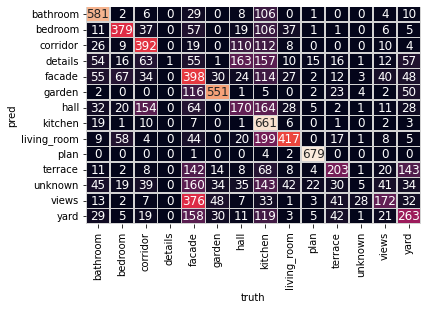

In [ ]:
classes = data_loaders["train"].dataset.classes

plot_confusion_matrix(pred, truth, classes)